## Importing Libraries

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
BatchNormalization._USE_V2_BEHAVIOR = False
import torchvision
import torch
import openpifpaf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
from openpifpaf import encoder
import tensorflow as tf
head_names = ['cif','caf']
import datetime



In [ ]:
INPUT_SHAPE = (385,385,3)
babli = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=None, input_shape=INPUT_SHAPE)
shuffle = Model(inputs=babli.input, outputs=babli.get_layer('block6a_expand_activation').output)

In [ ]:
shuffle.summary()

## Model (Training)

In [ ]:
class BatchNorm(Layer):
    def __init__(self, scale=True, center=True):
        super(BatchNorm, self).__init__()        
        self.bn = BatchNormalization(scale=scale, center=center, trainable=True)

    @tf.function
    def call(self, inputs, training=True):
        self.bn.trainable=training
        return self.bn(inputs)    
class CIF(Model):
    def __init__(self):
        super(CIF, self).__init__()
        self.conv  = tf.keras.layers.Conv2D(340, kernel_size=1, strides=(1, 1), padding='valid',  dilation_rate=(1, 1), use_bias=True)
        self.bn = BatchNorm()

    @tf.function
    def pixel_shuffle_tf(self,inputs, scale_factor):
        in_channels, in_height, in_width = inputs.shape

        out_channels = in_channels // (scale_factor * scale_factor)
        out_height = in_height * scale_factor
        out_width = in_width * scale_factor

        if scale_factor >= 1:
            input_view = tf.reshape(inputs,[out_channels,scale_factor, scale_factor, in_height, in_width])
            shuffle_out = tf.transpose(input_view,perm=[0, 3, 1, 4, 2])

        return tf.reshape(shuffle_out,[out_channels, out_height, out_width])  
    @tf.function    
    def call(self, inputs, training=True):
        x = inputs
        
        x = self.conv(x)
        x = self.bn(x)

        x=tf.transpose(x,perm=[0,3,1,2])
        y = None
        batch_size = x.shape[0]
#         batch_size = 1

        for i in range(x.shape[0]):
            if y==None:
                y = tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)
            else:
                y = tf.concat([y,tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)],axis=0)

        x = y
        
        x = x[:,:,:-1,:-1]

        classes_x = x[:, :17] 
        
        f_map = classes_x.shape[2]
        classes_x = tf.reshape(classes_x, [batch_size,17, 1, f_map, f_map])
        
        regs_x = x[:, 17:51]
        regs_x = tf.reshape(regs_x, [batch_size,17, 1, 2, f_map, f_map])
        
        regs_logb = x[:, 51:68]
        regs_logb = tf.reshape(regs_logb, [batch_size,17, 1, f_map, f_map])
        
        scales_x = x[:,68:85]
        scales_x = tf.reshape(scales_x, [batch_size,17, 1, f_map, f_map])
                
        return classes_x, regs_x, regs_logb, scales_x
class CAF(Model):
    '''
        Shufflenet Starter Head, made using netron
        structure of the exported onnx model
    '''
    
    
    def __init__(self):
        super(CAF, self).__init__()
        self.conv  = tf.keras.layers.Conv2D(
                                684, kernel_size=1, strides=(1, 1), padding='valid',  dilation_rate=(1, 1), use_bias=True)
        self.bn = BatchNorm()
    
    @tf.function
    def pixel_shuffle_tf(self,inputs, scale_factor):
        in_channels, in_height, in_width = inputs.shape

        out_channels = in_channels // (scale_factor * scale_factor)
        out_height = in_height * scale_factor
        out_width = in_width * scale_factor

        if scale_factor >= 1:
            input_view = tf.reshape(inputs,[out_channels,scale_factor, scale_factor, in_height, in_width])
            shuffle_out = tf.transpose(input_view,perm=[0, 3, 1, 4, 2])

        return tf.reshape(shuffle_out,[out_channels, out_height, out_width])
    
    @tf.function
    def call(self, inputs, training=True):
        x = inputs
        x = self.conv(x)
        x = self.bn(x)
        x=tf.transpose(x,perm=[0,3,1,2])
        
        y = None
        batch_size = x.shape[0]
#         batch_size = 1
        
        for i in range(x.shape[0]):
            if y==None:
                y = tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)
            else:
                y = tf.concat([y,tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)],axis=0)
        
        x = y
        
        x = x[:,:,:-1,:-1]
        
        classes_x = x[:, :19] 
        f_map = classes_x.shape[2]
        classes_x = tf.reshape(classes_x, [batch_size,19, 1, f_map, f_map])
#         classes_x = tf.math.sigmoid(classes_x)
        
        regs_x = x[:, 19:95]
        regs_x = tf.reshape(regs_x, [batch_size,19, 2, 2, f_map, f_map])
        
        
        regs_logb = x[:, 95:133]
        regs_logb = tf.reshape(regs_logb, [batch_size,19, 2, f_map, f_map])
        
        scales_x = x[:,133:]
        scales_x = tf.reshape(scales_x, [batch_size,19, 2, f_map, f_map])
                
        return classes_x, regs_x, regs_logb, scales_x    
class PIFPAF(Model):
    def __init__(self):
        super(PIFPAF, self).__init__()
#         self.shuffle = Shufflenet2k()
        babli = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=None, input_shape=INPUT_SHAPE)
        self.shuffle = Model(inputs=babli.input, outputs=babli.get_layer('block6a_expand_activation').output)

#         self.shuffle = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=None, input_shape=INPUT_SHAPE)
        self.cif = CIF()
        self.caf = CAF()

    @tf.function    
    def call(self, inputs, training=True):
    
        x = self.shuffle(inputs,training)
        print(" SHUFFLE SHAPE ", x.shape)
        x_cif0, x_cif1, x_cif2, x_cif3 = self.cif(x,training)
        x_caf0, x_caf1, x_caf2, x_caf3 = self.caf(x,training)
        return [x_cif0, x_cif1, x_cif2, x_cif3], [x_caf0, x_caf1, x_caf2, x_caf3]

In [ ]:
tert = np.random.rand(2,145,145,3).astype(np.float32)
pifpaf = PIFPAF()
b = pifpaf(tert)
pifpaf.summary()

In [ ]:
len(b), b[0][0].shape

## Losses

In [ ]:
def custom_loss(outputs, targets, vec):
    x = outputs
    t = targets
    
    def confidence_loss_tf(x_confidence, target_confidence):
        
        
        bce_masks=tf.math.is_nan(target_confidence)
        bce_masks = tf.math.logical_not(bce_masks)
        if not tf.math.reduce_any(bce_masks):
            return tf.convert_to_tensor(np.nan)
        x_confidence = x_confidence[:, :, 0]

        batch_size = x_confidence.shape[0]
        bce_target=tf.boolean_mask(target_confidence, bce_masks)
        bce_weight = 1.0
        x_confidence = tf.boolean_mask(x_confidence, bce_masks)
        bce_weight=tf.zeros_like(bce_target)

        bce_weight=tf.where(bce_target == 1, x_confidence, bce_weight)
        bce_weight=tf.where(bce_target == 0, -x_confidence, bce_weight)
        bce_weight = tf.math.pow((1.0 + tf.math.exp(bce_weight)),-1)

        ce_loss=tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=bce_target, 
                                                                      logits=x_confidence)*bce_weight)/(1000*batch_size)
        return ce_loss


    


    def laplace_loss_tf(x1, x2, logb, t1, t2, weight=None):
        norm=tf.norm(tf.stack([x1,x2])-tf.stack([t1,t2]), ord='euclidean', axis=0)
        logb = 3.0 * tf.math.tanh(logb / 3.0)

        losses = 0.694 + logb + norm * tf.math.exp(-logb)
        losses = losses * weight
        return tf.reduce_sum(losses)

    def localization_loss_tf( x_regs, x_logbs, target_regs):
        
        batch_size = target_regs[0].shape[0]
        reg_losses = []
        for i, target_reg in enumerate(target_regs):
            
            target_reg = target_reg
            
            reg_masks=tf.math.is_nan(target_reg[:,:,0])
            reg_masks = tf.math.logical_not(reg_masks)
            if not tf.math.reduce_any(reg_masks):
                reg_losses.append(tf.convert_to_tensor(np.nan))
                continue
                
            x_regs = tf.convert_to_tensor(x_regs)
            target_reg = tf.convert_to_tensor(target_reg)
            x_logbs = tf.convert_to_tensor(x_logbs)

            a,b,c,d,e  =   x_regs[:, :, i, 0],  x_regs[:, :, i, 1],  x_logbs[:, :, i],  target_reg[:, :, 0], target_reg[:, :, 1]
            reg_losses.append(laplace_loss_tf(
                a[reg_masks],
                b[reg_masks],
                c[reg_masks],
                d[reg_masks],
                e[reg_masks],
                weight=0.1,
            ) / (100.0 * batch_size))

        return reg_losses

    def scale_losses_tf(x_scales, target_scales):
        batch_size = x_scales.shape[0]
        return [
#             logl1_loss_tf(
#                 tf.boolean_mask(x_scales[:,:,i], tf.math.logical_not(tf.math.is_nan(target_scale))),
#                 tf.boolean_mask(target_scale, tf.math.logical_not(tf.math.is_nan(target_scale)),
#                 reduction='sum',
#             ) / (100.0 * batch_size)
#             for i, target_scale in enumerate(target_scales)
#         ]
                
                logl1_loss_tf(
                tf.boolean_mask(x_scales[:,:,i], tf.math.logical_not(tf.math.is_nan(target_scale))),
                tf.boolean_mask(target_scale, tf.math.logical_not(tf.math.is_nan(target_scale))),
                reduction='sum',
            ) / (100.0 * batch_size)
            for i, target_scale in enumerate(target_scales)
        ]
    
    
    def logl1_loss_tf(logx, t, **kwargs):
        """Swap in replacement for functional.l1_loss."""
        logt = tf.math.log(t)
        res = tf.math.abs(logx-logt)
        res = tf.reduce_sum(res)
        return res


    def margin_losses_tf( x_regs, target_regs, *, target_confidence):
        return []


    x_confidence, x_regs, x_logbs, x_scales = x

    assert len(t) == 3 or 5
    running_t = iter(t)
    target_confidence = next(running_t)
    target_regs = [next(running_t) for _ in range(vec)]
    target_scales = [next(running_t) for _ in range(vec)]
    
    #print(" confidence shape", x_confidence.shape )

    ce_loss = confidence_loss_tf(x_confidence, target_confidence)
    reg_losses = localization_loss_tf(x_regs, x_logbs, target_regs)
    scale_losses = scale_losses_tf(x_scales, target_scales)
    margin_losses = margin_losses_tf(x_regs, target_regs,target_confidence=target_confidence)
    return [ce_loss] + reg_losses + scale_losses + margin_losses
def create_input_batch(data):
    da = data.numpy()
    
    #da = (da - np.min(da))/np.ptp(da)
    da = np.transpose(da, (0,2,3,1))
#     da = da[:,,:-1,:]

    return tf.convert_to_tensor(da)
def calculate_loss(res, target_batch):
    #print(" RES SHAPE", res[0][1].shape)
    cif_loss = custom_loss(res[0], target_batch[0], 1)
    caf_loss = custom_loss(res[1], target_batch[1], 2)
    flat_head_losses = []
    flat_head_losses.extend(cif_loss)
    flat_head_losses.extend(caf_loss)
    lambdas = [1.0,1.0,0.2,1.0 ,1.0, 1.0, 0.2,0.2]
#     lambdas = [1.0,0.0,0.0,1.0 ,0.0, 0.0, 0.0,0.0]
#     lambdas=[1.0,1.0]
    loss_values=[]
    
    
    
    for lam, l in zip(lambdas, flat_head_losses):
        r=tf.math.multiply(lam,l)
        if not tf.math.is_nan(r):
            loss_values.append(r)
    a=tf.constant(np.nan)
    total_loss = tf.cond(tf.reduce_sum(loss_values)==0  ,lambda: a, lambda: tf.reduce_sum(loss_values))
    return total_loss,flat_head_losses
def calculate_loss(res, target_batch):
    #print(" RES SHAPE", res[0][1].shape)
    cif_loss = custom_loss(res[0], target_batch[0], 1)
    caf_loss = custom_loss(res[1], target_batch[1], 2)
    flat_head_losses = []
    flat_head_losses.extend(cif_loss)
    flat_head_losses.extend(caf_loss)
    lambdas = [1.0,1.0,0.2,1.0 ,1.0, 1.0, 0.2,0.2]
#     lambdas = [1.0,0.0,0.0,1.0 ,0.0, 0.0, 0.0,0.0]
#     lambdas=[1.0,1.0]
    loss_values=[]
    
    
    
    for lam, l in zip(lambdas, flat_head_losses):
        r=tf.math.multiply(lam,l)
        if not tf.math.is_nan(r):
            loss_values.append(r)
    a=tf.constant(np.nan)
    total_loss = tf.cond(tf.reduce_sum(loss_values)==0  ,lambda: a, lambda: tf.reduce_sum(loss_values))
    return total_loss,flat_head_losses

## Dataset

In [ ]:
IMG_SHAPE     = 385
AUGUMENTATION = True
IMAGE_DIR     = '/home/unreal/shared_folder/unrealai/coco17/train2017'
ANN_DIR       = '/home/unreal/shared_folder/unrealai/coco17/annotations/person_keypoints_train2017.json'
BATCH_SIZE    = 16
NUM_WORKERS   = 2
SHUFFLE       = True
PIN_MEMORY    = False

In [ ]:


def create_input_batch(data):
    da = data.numpy()
    
    #da = (da - np.min(da))/np.ptp(da)
    da = np.transpose(da, (0,2,3,1))
#     da = da[:,,:-1,:]

    return tf.convert_to_tensor(da)

base_vision = torchvision.models.ShuffleNetV2([4, 8, 4], [24, 348, 696, 1392, 1392])
blocks = [base_vision.conv1, 
        base_vision.stage2, base_vision.stage3, base_vision.stage4, base_vision.conv5,]
basenet = openpifpaf.network.basenetworks.BaseNetwork(
        torch.nn.Sequential(*blocks),
        "shufflenetv2k16w",
        stride=16,
        out_features=1392,
    )
head_metas = openpifpaf.datasets.headmeta.factory(head_names)
headnets = [openpifpaf.network.heads.CompositeFieldFused(h, basenet.out_features) for h in head_metas]
net_cpu = openpifpaf.network.nets.Shell(basenet, headnets)
preprocess = openpifpaf.datasets.factory.train_cocokp_preprocess_factory(
        square_edge=IMG_SHAPE,
        augmentation=AUGUMENTATION,
        extended_scale=False,
        orientation_invariant=0.0,
        rescale_images=1.0)
original_transforms = encoder.factory(net_cpu.head_nets, net_cpu.base_net.stride)
train_data = openpifpaf.datasets.Coco(
         image_dir = IMAGE_DIR,
         ann_file  = ANN_DIR,
         preprocess=preprocess,
         target_transforms=original_transforms,
         n_images=None,
         image_filter='keypoint-annotations',
         category_ids=[1],
    )
def collate_images_targets_meta(batch):
    images = torch.utils.data.dataloader.default_collate([b[0] for b in batch])
    targets = torch.utils.data.dataloader.default_collate([b[1] for b in batch])
    metas = [b[2] for b in batch]
    return images, targets, metas
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=BATCH_SIZE,
                                           shuffle=SHUFFLE,
                                           pin_memory=PIN_MEMORY,
                                           num_workers=NUM_WORKERS,
                                           drop_last=True,
                                           collate_fn=collate_images_targets_meta)
print("Data Loaded")




## Optimizer

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = tf.keras.experimental.CosineDecay(
    initial_learning_rate = 1e-4,
    decay_steps = 20000,
    alpha=0.0
)
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,
#     decay_rate=0.8,
#     staircase=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

## Initialising 

In [ ]:

print("Creating Model")

model = PIFPAF()
tert = np.random.rand(16,IMG_SHAPE,IMG_SHAPE,3).astype(np.float32)
bert = model(tert)
# model.load_weights('/home/unreal/shared_folder/model/new_mobile/epoch_35/atom3001.h5')
print(" Creating Logs ")

# current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# print("current_time", current_time)
# train_log_dir = 'logs/Efficient/' + str(current_time) + '/train'
# print(" train_log_dir ",train_log_dir) 
# test_log_dir =  'logs/Efficient/' + str(current_time) + '/test'

# print(" Logs Created ")

# train_summary_writer = tf.summary.create_file_writer(train_log_dir)
# test_summary_writer = tf.summary.create_file_writer(test_log_dir)

# print("Summary Created")



## Training

In [ ]:

# model.load_weights("/home/unreal/shared_folder/model/mobile_final/epoch_62/atom3001.h5")

kk=0
arr=[]
prev_weights= []
epochs = 100
loss_value = 0.0
tt=0
import time
#@tf.function
def train_step(data, target_batch):
    with tf.GradientTape() as tape:
        res = model(tf.convert_to_tensor(data), training=True)  # Logits for this minibatch  
        loss_value,flat_head_losses = calculate_loss(res,tt)
    grads = tape.gradient(loss_value, model.trainable_variables)
    a=[]
    b=[]
    wei=model.trainable_variables
    for i in range(len(grads)):
        x=tf.math.reduce_sum(grads[i])
        y=tf.math.reduce_sum(wei[i])
        a.append(grads[i])
        b.append(wei[i])
        
    
    optimizer.apply_gradients(zip(a, b))
    return loss_value,flat_head_losses,res,grads

arr=['cif_confidence','cif_local','cif_scale', 'cif_margin','caf_confidence','caf_local','caf_scale', 'caf_margin']
print(" Lenth of dataloader " , len(train_loader))

In [ ]:
for epoch in range(0,epochs):
    step=0
    it = iter(train_loader)
    while(True):
        try:
            (data, target, meta) = next(it)
            step+=1
        except Exception as e:
            step+=1
            if step>=len(train_loader):
                break
            continue
        if step>=len(train_loader):
            break
        
        target_batch = target
        data = create_input_batch(data)
        ref_start = time.time()
        tt=[]
        for i in target_batch:
            aa=[]
            for j in i:
                aa.append(tf.convert_to_tensor(j))
            tt.append(aa)
        total_loss,flat_head_losses,res,grads=train_step(data, tt)        
        
        print(" Epoch - ",epoch, "Step  " , step," total Loss ", total_loss.numpy(), time.time()-ref_start)
    
        with train_summary_writer.as_default():
            tf.summary.scalar('loss', total_loss, step=(step+(epoch*len(train_loader))))
            for i in range(8):
                tf.summary.scalar(str(arr[i]), flat_head_losses[i], step=(step+(epoch*len(train_loader))))

        if step%1000==0:
            print("Hello EfficientNet "+str(step))
            model.save_weights("/home/unreal/shared_folder/POSE/epoch_"+str(epoch)+"/"+'atom{}.h5'.format(step + 1))




## Inference

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [36]:
import matplotlib
import requests
import PIL, io
import numpy as np
import os
os.environ['CUDA_VISIBLE_DEVICES']=''
import tensorflow as tf
from Decoder import CifCaf, KeypointPainter, image_canvas

DIM = 385

image_response = requests.get('https://previews.123rf.com/images/piksel/piksel1301/piksel130100090/17604593-casual-young-man-standing.jpg')
image_response = requests.get('https://raw.githubusercontent.com/vita-epfl/openpifpaf/master/docs/coco/000000081988.jpg')
# image_response = requests.get('https://www.telegraph.co.uk/content/dam/football/2017/03/08/JS122863774_Getty-Images-Europe_FC-Barcelona-v-Paris-Saint-Germain-UEFA-Champions-League-Round_trans_NvBQzQNjv4BqqVzuuqpFlyLIwiB6NTmJwZ_d2gJnLGFVBaEhcbHfaHk.jpg?imwidth=450')
# image_response = requests.get("https://media3.s-nbcnews.com/j/newscms/2018_17/2413576/b_dib_metzl1squat2_170213_40fb12f1c35eacbbde96cd69a7361022.fit-760w.jpg") 
pil_im = PIL.Image.open(io.BytesIO(image_response.content)).convert('RGB')
pil_im = pil_im.resize((DIM,DIM))
im = np.asarray(pil_im)

data1=np.expand_dims(im,axis=0)


In [37]:
INPUT_SHAPE = (DIM,DIM,3)
class BatchNorm(Layer):
    def __init__(self, scale=True, center=True):
        super(BatchNorm, self).__init__()        
        self.bn = BatchNormalization(scale=scale, center=center, trainable=True)

    @tf.function
    def call(self, inputs, training=True):
        self.bn.trainable=training
        return self.bn(inputs)    
class CIF(Model):
    def __init__(self):
        super(CIF, self).__init__()
        self.conv  = tf.keras.layers.Conv2D(340, kernel_size=1, strides=(1, 1), padding='valid',  dilation_rate=(1, 1), use_bias=True)
        self.bn = BatchNorm()

    @tf.function
    def pixel_shuffle_tf(self,inputs, scale_factor):
        in_channels, in_height, in_width = inputs.shape

        out_channels = in_channels // (scale_factor * scale_factor)
        out_height = in_height * scale_factor
        out_width = in_width * scale_factor

        if scale_factor >= 1:
            input_view = tf.reshape(inputs,[out_channels,scale_factor, scale_factor, in_height, in_width])
            shuffle_out = tf.transpose(input_view,perm=[0, 3, 1, 4, 2])

        return tf.reshape(shuffle_out,[out_channels, out_height, out_width])  
    @tf.function    
    def call(self, inputs, training=True):
        x = inputs
        x = self.conv(x)
        x = self.bn(x)

        x=tf.transpose(x,perm=[0,3,1,2])
        y = None
        batch_size = 1
# #         batch_size = 1
#         y = None
#         for i in range(1):
#             if y==None:
#                 y = tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)
#             else:
#                 y = tf.concat([y,tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)],axis=0)

#         x = y
        upscale_factor = 2
        x = tf.squeeze(x, axis=0)
        channels = x.shape[0]
        height = x.shape[1]
        width = x.shape[2]
        
        t11 = tf.reshape(x, (int(channels/upscale_factor**2), upscale_factor, upscale_factor ,height*width)) # (3,2, 2, 4)
        t12 = tf.transpose(t11, (0, 1, 3, 2 ))
        t12 = tf.reshape(t12, ( int(channels/upscale_factor**2), upscale_factor, height, width, upscale_factor)) #(3, 2, 2,2, 2)
        t13 = tf.reshape(t12, (int(channels/upscale_factor**2), upscale_factor, height, width*upscale_factor))
        t12 = tf.transpose(t13, (0, 2, 1, 3 ))
        t12 = tf.reshape(t12, (1,int(channels/upscale_factor**2), upscale_factor* height, width*upscale_factor))
#         t12 = tf.expand_dims(t12, axis=0)
        x = t12
        
        x = x[:,:,:-1,:-1]

        classes_x = x[:, :17] 
        
        f_map = classes_x.shape[2]
        classes_x = tf.reshape(classes_x, [batch_size,17, 1, f_map, f_map])
        
        regs_x = x[:, 17:51]
        regs_x = tf.reshape(regs_x, [batch_size,17, 1, 2, f_map, f_map])
        
        regs_logb = x[:, 51:68]
        regs_logb = tf.reshape(regs_logb, [batch_size,17, 1, f_map, f_map])
        
        scales_x = x[:,68:85]
        scales_x = tf.reshape(scales_x, [batch_size,17, 1, f_map, f_map])
                
        return classes_x, regs_x, regs_logb, scales_x
class CAF(Model):
    '''
        Shufflenet Starter Head, made using netron
        structure of the exported onnx model
    '''
    
    
    def __init__(self):
        super(CAF, self).__init__()
        self.conv  = tf.keras.layers.Conv2D(
                                684, kernel_size=1, strides=(1, 1), padding='valid',  dilation_rate=(1, 1), use_bias=True)
        self.bn = BatchNorm()
    
    @tf.function
    def pixel_shuffle_tf(self,inputs, scale_factor):
        in_channels, in_height, in_width = inputs.shape

        out_channels = in_channels // (scale_factor * scale_factor)
        out_height = in_height * scale_factor
        out_width = in_width * scale_factor

        if scale_factor >= 1:
            input_view = tf.reshape(inputs,[out_channels,scale_factor, scale_factor, in_height, in_width])
            shuffle_out = tf.transpose(input_view,perm=[0, 3, 1, 4, 2])

        return tf.reshape(shuffle_out,[out_channels, out_height, out_width])
    
    @tf.function
    def call(self, inputs, training=True):
        x = inputs
        x = self.conv(x)
        x = self.bn(x)
        x=tf.transpose(x,perm=[0,3,1,2])
        
        batch_size = 1
# #         batch_size = 1
#         y = None
#         for i in range(1):
#             if y==None:
#                 y = tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)
#             else:
#                 y = tf.concat([y,tf.expand_dims(self.pixel_shuffle_tf(x[i],2), axis=0)],axis=0)

#         x = y
        upscale_factor = 2
        x = tf.squeeze(x, axis=0)
        channels = x.shape[0]
        height = x.shape[1]
        width = x.shape[2]
        
        t11 = tf.reshape(x, (int(channels/upscale_factor**2), upscale_factor, upscale_factor ,height*width)) # (3,2, 2, 4)
        t12 = tf.transpose(t11, (0, 1, 3, 2 ))
        t12 = tf.reshape(t12, ( int(channels/upscale_factor**2), upscale_factor, height, width, upscale_factor)) #(3, 2, 2,2, 2)
        t13 = tf.reshape(t12, (int(channels/upscale_factor**2), upscale_factor, height, width*upscale_factor))
        t12 = tf.transpose(t13, (0, 2, 1, 3 ))
        t12 = tf.reshape(t12, (1,int(channels/upscale_factor**2), upscale_factor* height, width*upscale_factor))
#         t12 = tf.expand_dims(t12, axis=0)
        x = t12
        
        x = x[:,:,:-1,:-1]
        
        classes_x = x[:, :19] 
        f_map = classes_x.shape[2]
        classes_x = tf.reshape(classes_x, [batch_size,19, 1, f_map, f_map])
#         classes_x = tf.math.sigmoid(classes_x)
        
        regs_x = x[:, 19:95]
        regs_x = tf.reshape(regs_x, [batch_size,19, 2, 2, f_map, f_map])
        
        
        regs_logb = x[:, 95:133]
        regs_logb = tf.reshape(regs_logb, [batch_size,19, 2, f_map, f_map])
        
        scales_x = x[:,133:]
        scales_x = tf.reshape(scales_x, [batch_size,19, 2, f_map, f_map])
                
        return classes_x, regs_x, regs_logb, scales_x    
class PIFPAF(Model):
    def __init__(self):
        super(PIFPAF, self).__init__()
        babli = tf.keras.applications.EfficientNetB2(include_top=False, weights='imagenet', input_tensor=None, input_shape=INPUT_SHAPE)
        self.shuffle = Model(inputs=babli.input, outputs=babli.get_layer('block6a_expand_activation').output)
        self.cif=CIF()
        self.caf=CAF()
    @tf.function
    def fun(self,img,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]):
        im=img/255
        im=tf.transpose(im,perm=[2,0,1])
        arr=[]
        for i in range(3):
            arr.append((im[i]-mean[i])/std[i])
        arr=tf.convert_to_tensor(arr)
        arr=tf.transpose(arr,perm=[1,2,0])
        arr=tf.expand_dims(arr,0)
        
        return arr
    @tf.function
    def func(self,output):
        out_py=output
        map_s = output[0][0].shape[4]
        tt = []
        for j in out_py:
            temp1 =[]
            for i in j:
                if len(i.shape)==6:
                    if i.shape[1]==17:
                        i = tf.reshape(i,[1,17,2,map_s,map_s])
                    if i.shape[1]==19:
                        i = tf.reshape(i,[1,19,4,map_s,map_s])
                temp1.append(i)
            tt.append(temp1)
        cif_c = tf.concat([tt[0][0],tt[0][1],tt[0][2],tt[0][3]], axis=2)
        caf_c = tf.concat([tt[1][0],tt[1][1],tt[1][2],tt[1][3]], axis=2)
        val = []
        val2 = []
        for i in range(map_s):
            val.append(tf.range(0, map_s, 1, dtype=tf.float32))
            val2.append(tf.fill([map_s], float(i)))
        t = tf.stack([val, val2], axis=0)
        r = tf.expand_dims(t, 0)
        r = tf.expand_dims(r, 0)
        index_field = r
        a=cif_c[:, :, 1:3]
        a+=index_field
        cif_c=tf.concat([cif_c[:, :, 0:1],a,cif_c[:, :, 3:5]], axis=2)
        a=caf_c[:, :, 1:3]
        a+=index_field
        b=caf_c[:, :, 3:5]
        b+=index_field
        caf_c=tf.concat([caf_c[:, :, 0:1],a,b,caf_c[:, :, 5:9]],axis=2)
        tup=(1,2, 5, 7, 3, 4, 6, 8)
        a=caf_c[:,:,0:1]
        for i in tup:
            a=tf.concat([a,caf_c[:,:,i:i+1]],axis=2)
        caf_c=a
        final = [cif_c, caf_c]
        return final
    @tf.function
    def call(self,inputs,training=True):
        x=self.fun(inputs[0])
        x=self.shuffle(x,training)
        y =self.cif(x,training)
        z =self.caf(x,training)
        final=self.func([y,z])
        return final
tert = np.random.rand(2,DIM,DIM,3).astype(np.float32)
pifpaf = PIFPAF()
b = pifpaf(tert)

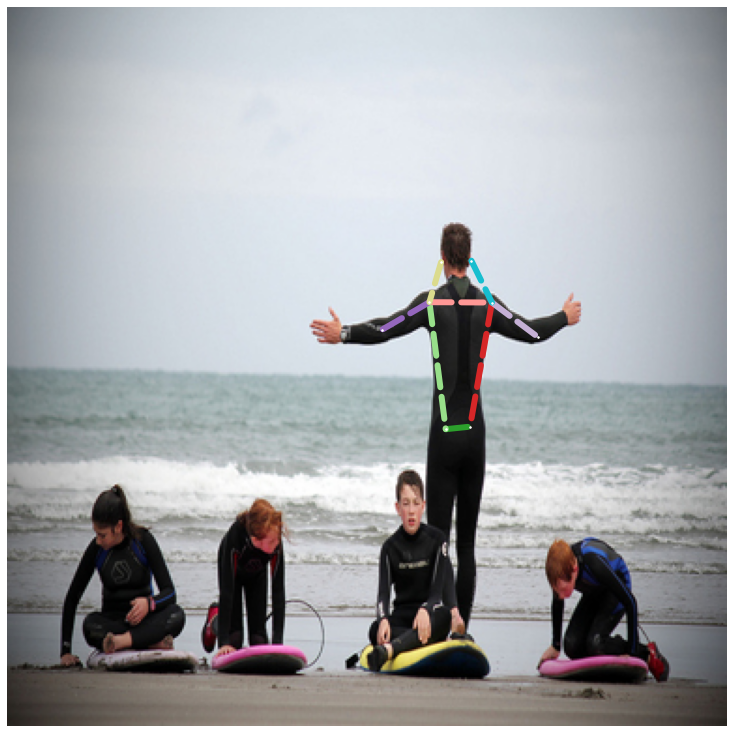

In [40]:
# pifpaf7=PIFPAF()
# pifpaf7 = tf.keras.models.load_model('../Models/Original_Models/Shufflenet/')
# final=pifpaf(data1.astype(np.float32),True)
pifpaf.load_weights('/home/unreal/shared_folder/POSE/EfficentD2/epoch_30/atom1001.h5')
# pifpaf.load_weights('/home/unreal/shared_folder/POSE_D4/epoch_13/atom7001.h5')

final=pifpaf(data1.astype(np.float32),False)

heads = [[],[]]
heads[0] = final[0][0].numpy()
heads[1] = final[1][0].numpy()

keypoint_painter = KeypointPainter(color_connections=True, linewidth=6)

predictions = []

keypoints = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist',
             'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']
skeleton = [(16, 14), (14, 12), (17, 15), (15, 13), (12, 13), (6, 12), (7, 13), (6, 7), (6, 8), (7, 9), (8, 10), (9, 11), (2, 3), (1, 2), (1, 3), (2, 4),
             (3, 5), (4, 6), (5, 7)]

decoder = CifCaf(keypoints=keypoints,skeleton=skeleton)
predictions = decoder.decode(heads)


import matplotlib
with image_canvas(data1[0]) as ax:
    keypoint_painter.annotations(ax, predictions)

In [15]:
#cyclic larning rate
#rmsprop

## TFLite Inference B2


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization

In [ ]:
# model = PIFPAF()

In [ ]:
# model.load_weights('/home/unreal/shared_folder/POSE/epoch_24/atom6001.h5')

In [ ]:
pifpaf.save('../Models/Models/Efficent_D2_145/')

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

In [ ]:
ls ../TFLite_Models

In [ ]:
!tflite_convert \
  --saved_model_dir=../Models/Models/Efficent_D2_145/ \
  --output_file=../TFLite_Models/EfficientD2_145.tflite


## Testing

In [ ]:
import tensorflow as tf
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''
model = tf.keras.models.Sequential([tf.keras.layers.Dense(10)])
model.compile(tf.keras.optimizers.SGD(), loss='mse')
round(model.optimizer.lr.numpy(), 5)

In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)


In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=15, callbacks=[callback], verbose=0)
round(model.optimizer.lr.numpy(), 5)

In [ ]:
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops
from tensorflow.python.eager import context

def cyclic_learning_rate(global_step,
                         learning_rate=0.01,
                         max_lr=0.1,
                         step_size=20.,
                         gamma=0.99994,
                         mode='triangular',
                         name=None):
  """Applies cyclic learning rate (CLR).
     From the paper:
     Smith, Leslie N. "Cyclical learning
     rates for training neural networks." 2017.
     [https://arxiv.org/pdf/1506.01186.pdf]
      This method lets the learning rate cyclically
     vary between reasonable boundary values
     achieving improved classification accuracy and
     often in fewer iterations.
      This code varies the learning rate linearly between the
     minimum (learning_rate) and the maximum (max_lr).
      It returns the cyclic learning rate. It is computed as:
       ```python
       cycle = floor( 1 + global_step /
        ( 2 * step_size ) )
      x = abs( global_step / step_size – 2 * cycle + 1 )
      clr = learning_rate +
        ( max_lr – learning_rate ) * max( 0 , 1 - x )
       ```
      Polices:
        'triangular':
          Default, linearly increasing then linearly decreasing the
          learning rate at each cycle.
         'triangular2':
          The same as the triangular policy except the learning
          rate difference is cut in half at the end of each cycle.
          This means the learning rate difference drops after each cycle.
         'exp_range':
          The learning rate varies between the minimum and maximum
          boundaries and each boundary value declines by an exponential
          factor of: gamma^global_step.
       Example: 'triangular2' mode cyclic learning rate.
        '''python
        ...
        global_step = tf.Variable(0, trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate=
          clr.cyclic_learning_rate(global_step=global_step, mode='triangular2'))
        train_op = optimizer.minimize(loss_op, global_step=global_step)
        ...
         with tf.Session() as sess:
            sess.run(init)
            for step in range(1, num_steps+1):
              assign_op = global_step.assign(step)
              sess.run(assign_op)
        ...
         '''
       Args:
        global_step: A scalar `int32` or `int64` `Tensor` or a Python number.
          Global step to use for the cyclic computation.  Must not be negative.
        learning_rate: A scalar `float32` or `float64` `Tensor` or a
        Python number.  The initial learning rate which is the lower bound
          of the cycle (default = 0.1).
        max_lr:  A scalar. The maximum learning rate boundary.
        step_size: A scalar. The number of iterations in half a cycle.
          The paper suggests step_size = 2-8 x training iterations in epoch.
        gamma: constant in 'exp_range' mode:
          gamma**(global_step)
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
        name: String.  Optional name of the operation.  Defaults to
          'CyclicLearningRate'.
       Returns:
        A scalar `Tensor` of the same type as `learning_rate`.  The cyclic
        learning rate.
      Raises:
        ValueError: if `global_step` is not supplied.
      @compatibility(eager)
      When eager execution is enabled, this function returns
      a function which in turn returns the decayed learning
      rate Tensor. This can be useful for changing the learning
      rate value across different invocations of optimizer functions.
      @end_compatibility
  """
  if global_step is None:
    raise ValueError("global_step is required for cyclic_learning_rate.")
  with ops.name_scope(name, "CyclicLearningRate",
                      [learning_rate, global_step]) as name:
    learning_rate = ops.convert_to_tensor(learning_rate, name="learning_rate")
    dtype = learning_rate.dtype
    global_step = math_ops.cast(global_step, dtype)
    step_size = math_ops.cast(step_size, dtype)
    def cyclic_lr():
      """Helper to recompute learning rate; most helpful in eager-mode."""
      # computing: cycle = floor( 1 + global_step / ( 2 * step_size ) )
      double_step = math_ops.multiply(2., step_size)
      global_div_double_step = math_ops.divide(global_step, double_step)
      cycle = math_ops.floor(math_ops.add(1., global_div_double_step))
      # computing: x = abs( global_step / step_size – 2 * cycle + 1 )
      double_cycle = math_ops.multiply(2., cycle)
      global_div_step = math_ops.divide(global_step, step_size)
      tmp = math_ops.subtract(global_div_step, double_cycle)
      x = math_ops.abs(math_ops.add(1., tmp))
      # computing: clr = learning_rate + ( max_lr – learning_rate ) * max( 0, 1 - x )
      a1 = math_ops.maximum(0., math_ops.subtract(1., x))
      a2 = math_ops.subtract(max_lr, learning_rate)
      clr = math_ops.multiply(a1, a2)
      if mode == 'triangular2':
        clr = math_ops.divide(clr, math_ops.cast(math_ops.pow(2, math_ops.cast(
            cycle-1, tf.int32)), tf.float32))
      if mode == 'exp_range':
        clr = math_ops.multiply(math_ops.pow(gamma, global_step), clr)
      return math_ops.add(clr, learning_rate, name=name)
    if not context.executing_eagerly():
      cyclic_lr = cyclic_lr()
    return cyclic_lr

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.executing_eagerly()) # => True

rates = []

for i in range(0, 250):
    x = cyclic_learning_rate(i, mode='exp_range', gamma=.995)#997)
    rates.append(x())

plt.xlabel('iterations (epochs)')
plt.ylabel('learning rate')
plt.plot(range(250), rates)

In [ ]:


callback = tf.keras.callbacks.LearningRateScheduler(cyclic_learning_rate, verbose=1)
history = model.fit(np.arange(100).reshape(5, 20), np.zeros(5),
                    epochs=15, callbacks=[callback], verbose=0)
round(model.optimizer.lr.numpy(), 5)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class SGDRScheduler(Callback):
    '''Cosine annealing learning rate scheduler with periodic restarts.

    # Usage
        ```python
            schedule = SGDRScheduler(min_lr=1e-5,
                                     max_lr=1e-2,
                                     steps_per_epoch=np.ceil(epoch_size/batch_size),
                                     lr_decay=0.9,
                                     cycle_length=5,
                                     mult_factor=1.5)
            model.fit(X_train, Y_train, epochs=100, callbacks=[schedule])
        ```

    # Arguments
        min_lr: The lower bound of the learning rate range for the experiment.
        max_lr: The upper bound of the learning rate range for the experiment.
        steps_per_epoch: Number of mini-batches in the dataset. Calculated as `np.ceil(epoch_size/batch_size)`. 
        lr_decay: Reduce the max_lr after the completion of each cycle.
                  Ex. To reduce the max_lr by 20% after each cycle, set this value to 0.8.
        cycle_length: Initial number of epochs in a cycle.
        mult_factor: Scale epochs_to_restart after each full cycle completion.

    # References
        Blog post: jeremyjordan.me/nn-learning-rate
        Original paper: http://arxiv.org/abs/1608.03983
    '''
    def __init__(self,
                 min_lr,
                 max_lr,
                 steps_per_epoch,
                 lr_decay=1,
                 cycle_length=10,
                 mult_factor=2):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.lr_decay = lr_decay

        self.batch_since_restart = 0
        self.next_restart = cycle_length

        self.steps_per_epoch = steps_per_epoch

        self.cycle_length = cycle_length
        self.mult_factor = mult_factor

        self.history = {}

    def clr(self):
        '''Calculate the learning rate.'''
        fraction_to_restart = self.batch_since_restart / (self.steps_per_epoch * self.cycle_length)
        lr = self.min_lr + 0.5 * (self.max_lr - self.min_lr) * (1 + np.cos(fraction_to_restart * np.pi))
        return lr

    def on_train_begin(self, logs={}):
        '''Initialize the learning rate to the minimum value at the start of training.'''
        logs = logs or {}
        tf.keras.backend.set_value(self.model.optimizer.lr, self.max_lr)

    def on_batch_end(self, batch, logs={}):
        '''Record previous batch statistics and update the learning rate.'''
        logs = logs or {}
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        self.batch_since_restart += 1
        tf.keras.backend.set_value(self.model.optimizer.lr, self.clr())

    def on_epoch_end(self, epoch, logs={}):
        '''Check for end of current cycle, apply restarts when necessary.'''
        if epoch + 1 == self.next_restart:
            self.batch_since_restart = 0
            self.cycle_length = np.ceil(self.cycle_length * self.mult_factor)
            self.next_restart += self.cycle_length
            self.max_lr *= self.lr_decay
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs={}):
        '''Set weights to the values from the end of the most recent cycle for best performance.'''
        self.model.set_weights(self.best_weights)